### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.

### Notes

In the future, may want to use larger, publicly available dataset from Open source Asset Pricing.
But that will require much more time to do feature engineering, impute missing values etc.


In [1]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', 150)
gc.enable()

In [2]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
# Functions for Optuna NNs

cv_nn_regularizer = 0.05

def create_snnn4_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn4_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def create_snnn6_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn6_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def objective_nn4(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn4_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit
    
    
def objective_nn6(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn6_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit


(28169, 41)

(3183, 41)

(3148, 41)

Number of features before transformation:  (28169, 38)
time to do feature proprocessing: 
Number of features after transformation:  (28169, 81) (3183, 81) (3135, 81) (3148, 81)
mae of a constant model 7.449410744523996
R2 of a constant model 0.0
fixed XGB train: 6.6404244439331155 0.20367387585733154
XGB val: 6.95041177187386 0.03588288720911759
XGB val extra: 7.6742518198770515 -0.025265240467944095
XGB test: 7.666935429587563 -0.011350303327938294
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04028216208954838 45.3790283203125
XGB train: 6.654836492171592 0.19714418801403566
XGB validation: 6.658730609524091 0.11395073365489594
XGB validation extra: 7.2109727702120345 0.09519933541519099
XGB test: 7.497737377821732 0.015670922109296548
Total time for hypermarameter optimization, XGB:  51.84708881378174
        n_estimators : 1410
           max_depth : 2
       learning_rate : 0.019697395408704774
    colsample_bytree : 0.06189

2022-09-23 14:21:26.201349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 14:21:26.202601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 14:21:26.203297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 14:21:26.204125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3673
Minimum Validation Loss: 86.1864
3329
Minimum Validation Loss: 85.2482


'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.5981956663745648,
 'l1_regularizer': 0.533997939793141}

300.36680030822754

[16, 0.5981956663745648, 0.533997939793141]

Time for hyperparameter optimization:  300.3793351650238 [16, 0.5981956663745648, 0.533997939793141]


'Optuna NN6'

{'neurons_base': 20,
 'l2_regularizer': 0.4474166990527885,
 'l1_regularizer': 0.6718686353254294}

398.7730875015259

[20, 0.4474166990527885, 0.6718686353254294]

Time for hyperparameter optimization:  398.7804763317108 [20, 0.4474166990527885, 0.6718686353254294]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(36869, 41)

(3792, 41)

(3777, 41)

Number of features before transformation:  (36869, 38)
time to do feature proprocessing: 
Number of features after transformation:  (36869, 82) (3792, 82) (3769, 82) (3777, 82)
mae of a constant model 7.452883011850004
R2 of a constant model 0.0
fixed XGB train: 7.065440972878254 0.0994790741821604
XGB val: 7.040802185351237 0.03911075687236154
XGB val extra: 7.224262924825025 0.021012537550721966
XGB test: 8.121556389185526 0.008777536521021867
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04074019149991959 48.02873969078064
XGB train: 7.1570619652758865 0.07184007474795484
XGB validation: 6.902472216245894 0.08638608768447231
XGB validation extra: 7.097823327034395 0.06496686346507374
XGB test: 8.09308443118756 0.01708651010256057
Total time for hypermarameter optimization, XGB:  118.1638035774231
        n_estimators : 1003
           max_depth : 2
       learning_rate : 0.02772785866868862
    colsample_bytree : 0.0923572327

'Optuna NN4'

{'neurons_base': 20,
 'l2_regularizer': 0.14659341212787755,
 'l1_regularizer': 0.10358834150704242}

312.78539967536926

[20, 0.14659341212787755, 0.10358834150704242]

Time for hyperparameter optimization:  312.7921733856201 [20, 0.14659341212787755, 0.10358834150704242]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.03436095242279934,
 'l1_regularizer': 0.00382583803681473}

308.3393876552582

[4, 0.03436095242279934, 0.00382583803681473]

Time for hyperparameter optimization:  308.34650182724 [4, 0.03436095242279934, 0.00382583803681473]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(46500, 41)

(4444, 41)

(4403, 41)

Number of features before transformation:  (46500, 38)
time to do feature proprocessing: 
Number of features after transformation:  (46500, 84) (4444, 84) (4381, 84) (4403, 84)
mae of a constant model 7.989002798117338
R2 of a constant model 0.0
fixed XGB train: 7.2936517680386475 0.08209972933431675
XGB val: 9.333257547436476 0.021046069322619876
XGB val extra: 7.449474573984752 0.005638548266455157
XGB test: 10.509277917328513 0.026280919917970325
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.025436589972033352 51.92677021026611
XGB train: 7.241671823627634 0.09783003114377553
XGB validation: 8.837739464119451 0.1338705926983017
XGB validation extra: 6.983415793741495 0.1367766827196445
XGB test: 10.455126096822962 0.03312929656455288
Total time for hypermarameter optimization, XGB:  113.02987217903137
        n_estimators : 1390
           max_depth : 3
       learning_rate : 0.012848719516021088
    colsample_bytree : 0.0502

'Optuna NN4'

{'neurons_base': 12,
 'l2_regularizer': 0.33542962507810037,
 'l1_regularizer': 0.04092182446068898}

442.4669165611267

[12, 0.33542962507810037, 0.04092182446068898]

Time for hyperparameter optimization:  442.4736125469208 [12, 0.33542962507810037, 0.04092182446068898]


'Optuna NN6'

{'neurons_base': 14,
 'l2_regularizer': 0.5820611527096509,
 'l1_regularizer': 0.04070333520983246}

350.195588350296

[14, 0.5820611527096509, 0.04070333520983246]

Time for hyperparameter optimization:  350.2071282863617 [14, 0.5820611527096509, 0.04070333520983246]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(54189, 41)

(5600, 41)

(5378, 41)

Number of features before transformation:  (54189, 38)
time to do feature proprocessing: 
Number of features after transformation:  (54189, 85) (5600, 85) (5328, 85) (5378, 85)
mae of a constant model 8.752338515572147
R2 of a constant model 0.0
fixed XGB train: 8.460377540557355 0.09478695171816742
XGB val: 8.121266540349747 0.02341051929316096
XGB val extra: 7.14492081057165 0.09535500673989161
XGB test: 10.172491280575692 -0.023785299258801684
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.6} 0.02460841108219025 54.1643226146698
XGB train: 8.608658999242866 0.06241628027424051
XGB validation: 8.015906366511864 0.050588332662405366
XGB validation extra: 7.086968289257709 0.11441644007085627
XGB test: 10.18616264539296 -0.02983434471573898
Total time for hypermarameter optimization, XGB:  88.48136854171753
        n_estimators : 1307
           max_depth : 3
       learning_rate : 0.016072619401629903
    colsample_bytree : 0.3693230

'Optuna NN4'

{'neurons_base': 6,
 'l2_regularizer': 0.08781999467307666,
 'l1_regularizer': 0.015331178841099306}

377.4676582813263

[6, 0.08781999467307666, 0.015331178841099306]

Time for hyperparameter optimization:  377.474080324173 [6, 0.08781999467307666, 0.015331178841099306]


'Optuna NN6'

{'neurons_base': 18,
 'l2_regularizer': 0.16990724414105837,
 'l1_regularizer': 0.09575469156608081}

396.937597990036

[18, 0.16990724414105837, 0.09575469156608081]

Time for hyperparameter optimization:  396.94439601898193 [18, 0.16990724414105837, 0.09575469156608081]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(66975, 41)

(7001, 41)

(6959, 41)

Number of features before transformation:  (66975, 38)
time to do feature proprocessing: 
Number of features after transformation:  (66975, 85) (7001, 85) (6933, 85) (6959, 85)
mae of a constant model 8.193904473345428
R2 of a constant model 0.0
fixed XGB train: 7.874313117501329 0.08200691614155542
XGB val: 7.207345751012461 0.02322371332411033
XGB val extra: 8.248476847443563 -0.000404904292881314
XGB test: 7.898967497669416 -0.003456817332593509
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.02596271982565146 57.172465085983276
XGB train: 7.697362877778516 0.13502410611921256
XGB validation: 6.974896013157732 0.09329290391275269
XGB validation extra: 7.909153030766222 0.09488718913828409
XGB test: 7.798712270829789 0.016362833305408553
Total time for hypermarameter optimization, XGB:  267.7598786354065
        n_estimators : 1276
           max_depth : 6
       learning_rate : 0.0038859982248689116
    colsample_bytree : 0.1318

'Optuna NN4'

{'neurons_base': 12,
 'l2_regularizer': 0.014445563379645343,
 'l1_regularizer': 0.3285768568643995}

421.989755153656

[12, 0.014445563379645343, 0.3285768568643995]

Time for hyperparameter optimization:  421.9972710609436 [12, 0.014445563379645343, 0.3285768568643995]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.39142603038297286,
 'l1_regularizer': 0.17226628778706604}

464.52202224731445

[4, 0.39142603038297286, 0.17226628778706604]

Time for hyperparameter optimization:  464.52834725379944 [4, 0.39142603038297286, 0.17226628778706604]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(79782, 41)

(6652, 41)

(6578, 41)

Number of features before transformation:  (79782, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79782, 85) (6652, 85) (6601, 85) (6578, 85)
mae of a constant model 8.177578740511931
R2 of a constant model 0.0
fixed XGB train: 7.578759184962916 0.06980816247898924
XGB val: 9.394118172059889 0.06141783879837537
XGB val extra: 8.97304328572841 0.0504247867091866
XGB test: 8.056289829722713 0.03265791761535808
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.06661135012690556 60.90030527114868
XGB train: 7.497806400742603 0.09524894911126458
XGB validation: 9.046355027411781 0.1375788591776138
XGB validation extra: 8.594332265669669 0.1418947818526307
XGB test: 8.124331809923092 0.017907553426464884
Total time for hypermarameter optimization, XGB:  188.6601402759552
        n_estimators : 1353
           max_depth : 2
       learning_rate : 0.0299425410947203
    colsample_bytree : 0.3728470415411479

'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.3475707627470549,
 'l1_regularizer': 0.010896462138784344}

744.9919004440308

[16, 0.3475707627470549, 0.010896462138784344]

Time for hyperparameter optimization:  745.0010869503021 [16, 0.3475707627470549, 0.010896462138784344]


'Optuna NN6'

{'neurons_base': 16,
 'l2_regularizer': 0.29250913208686663,
 'l1_regularizer': 0.00754582998150935}

550.5407195091248

[16, 0.29250913208686663, 0.00754582998150935]

Time for hyperparameter optimization:  550.5540819168091 [16, 0.29250913208686663, 0.00754582998150935]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(79162, 41)

(6405, 41)

(6311, 41)

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 59.61967921257019
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997
Total time for hypermarameter optimization, XGB:  32.28752064704895
        n_estimators : 887
           max_depth : 4
       learning_rate : 0.014820497285649877
    colsample_bytree : 0.05287

'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.1989453450040369,
 'l1_regularizer': 0.48469482188269486}

503.9389078617096

[16, 0.1989453450040369, 0.48469482188269486]

Time for hyperparameter optimization:  503.9455623626709 [16, 0.1989453450040369, 0.48469482188269486]


'Optuna NN6'

{'neurons_base': 18,
 'l2_regularizer': 0.1422223239579772,
 'l1_regularizer': 0.4977739512019431}

468.9196240901947

[18, 0.1422223239579772, 0.4977739512019431]

Time for hyperparameter optimization:  468.9257905483246 [18, 0.1422223239579772, 0.4977739512019431]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78167, 41)

(6645, 41)

(6830, 41)

Number of features before transformation:  (78167, 38)
time to do feature proprocessing: 
Number of features after transformation:  (78167, 85) (6645, 85) (7153, 85) (6830, 85)
mae of a constant model 8.657637923565364
R2 of a constant model 0.0
fixed XGB train: 8.424599302971748 0.06932567569973369
XGB val: 7.205442906705687 0.017613649442648427
XGB val extra: 8.9959779210455 0.04263099400683534
XGB test: 8.302334572958422 0.054104633202150865
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.02119253518883779 57.29244041442871
XGB train: 8.517964128371235 0.042083883893300755
XGB validation: 7.126140967651092 0.037942990462369486
XGB validation extra: 8.86798093836982 0.06632146197805111
XGB test: 8.233512577252704 0.06612552128577154
Total time for hypermarameter optimization, XGB:  96.18229651451111
        n_estimators : 890
           max_depth : 3
       learning_rate : 0.014314210474541591
    colsample_bytree : 0.87676986363

'Optuna NN4'

{'neurons_base': 4,
 'l2_regularizer': 0.005566829258662878,
 'l1_regularizer': 0.047014168905641696}

429.30008602142334

[4, 0.005566829258662878, 0.047014168905641696]

Time for hyperparameter optimization:  429.31626558303833 [4, 0.005566829258662878, 0.047014168905641696]


'Optuna NN6'

{'neurons_base': 12,
 'l2_regularizer': 0.095280413197644,
 'l1_regularizer': 0.004040455921596064}

539.7152388095856

[12, 0.095280413197644, 0.004040455921596064]

Time for hyperparameter optimization:  539.7273440361023 [12, 0.095280413197644, 0.004040455921596064]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(82271, 41)

(6871, 41)

(7164, 41)

Number of features before transformation:  (82271, 38)
time to do feature proprocessing: 
Number of features after transformation:  (82271, 85) (6871, 85) (7242, 85) (7164, 85)
mae of a constant model 9.14694595156696
R2 of a constant model 0.0
fixed XGB train: 8.254361909170475 0.12614226780069493
XGB val: 9.449122132568577 0.12513689412682905
XGB val extra: 8.648362248885388 0.11551765871956055
XGB test: 9.12573337441624 0.08931600612290269
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.6} 0.13100837139414145 61.264211893081665
XGB train: 8.203327465255919 0.13768405308397835
XGB validation: 9.190333450690995 0.17762612002484868
XGB validation extra: 8.424061984983226 0.16667205934762352
XGB test: 9.046573482378847 0.09976328883080177
Total time for hypermarameter optimization, XGB:  175.44329571723938
        n_estimators : 1338
           max_depth : 3
       learning_rate : 0.02301543114615618
    colsample_bytree : 0.452901923679

'Optuna NN4'

{'neurons_base': 8,
 'l2_regularizer': 0.028779697327068875,
 'l1_regularizer': 0.10546042443264578}

735.3141734600067

[8, 0.028779697327068875, 0.10546042443264578]

Time for hyperparameter optimization:  735.3216812610626 [8, 0.028779697327068875, 0.10546042443264578]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.2296090793107457,
 'l1_regularizer': 0.14544714532877354}

911.4648189544678

[4, 0.2296090793107457, 0.14544714532877354]

Time for hyperparameter optimization:  911.4718880653381 [4, 0.2296090793107457, 0.14544714532877354]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(85126, 41)

(6996, 41)

(7438, 41)

Number of features before transformation:  (85126, 38)
time to do feature proprocessing: 
Number of features after transformation:  (85126, 85) (6996, 85) (7235, 85) (7438, 85)
mae of a constant model 9.568563952267633
R2 of a constant model 0.0
fixed XGB train: 8.878114312259134 0.1395774098805702
XGB val: 8.566842004856916 0.08270306053234933
XGB val extra: 7.947055566247327 0.09823629798260503
XGB test: 8.06465854763708 0.10091837418718297
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.08362809829701279 61.621638774871826
XGB train: 8.98819121219944 0.11622908576019242
XGB validation: 8.480852493832245 0.09554060382072227
XGB validation extra: 7.8802184728169475 0.11013894999775631
XGB test: 8.046303183858319 0.10246535939346235
Total time for hypermarameter optimization, XGB:  134.04310774803162
        n_estimators : 1286
           max_depth : 2
       learning_rate : 0.016685092698833705
    colsample_bytree : 0.26430091620

'Optuna NN4'

{'neurons_base': 12,
 'l2_regularizer': 0.4474527029822935,
 'l1_regularizer': 0.3155784497991632}

953.9828810691833

[12, 0.4474527029822935, 0.3155784497991632]

Time for hyperparameter optimization:  953.9903702735901 [12, 0.4474527029822935, 0.3155784497991632]


'Optuna NN6'

{'neurons_base': 6,
 'l2_regularizer': 0.3414274442079619,
 'l1_regularizer': 0.009508803474530248}

944.0424916744232

[6, 0.3414274442079619, 0.009508803474530248]

Time for hyperparameter optimization:  944.0515551567078 [6, 0.3414274442079619, 0.009508803474530248]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(86525, 41)

(7274, 41)

(7655, 41)

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (7274, 86) (7557, 86) (7655, 86)
mae of a constant model 9.829729636954092
R2 of a constant model 0.0
fixed XGB train: 8.691436727915313 0.10293313911685331
XGB val: 9.717708335125423 0.03999212025983656
XGB val extra: 12.284157764400447 0.03759872132638431
XGB test: 10.465530780239735 -0.0063821723842552025
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04241707807354467 63.30662965774536
XGB train: 8.695012267727543 0.09907150614417448
XGB validation: 9.559585257648125 0.070611187303669
XGB validation extra: 11.972006867399784 0.08163841109742664
XGB test: 10.47468523195892 -0.0059672654136349035
Total time for hypermarameter optimization, XGB:  176.57903838157654
        n_estimators : 1208
           max_depth : 2
       learning_rate : 0.026811941280690824
    colsample_bytree : 0.050

'Optuna NN4'

{'neurons_base': 10,
 'l2_regularizer': 0.08804107230933476,
 'l1_regularizer': 0.05713431228950925}

813.4033334255219

[10, 0.08804107230933476, 0.05713431228950925]

Time for hyperparameter optimization:  813.4151263237 [10, 0.08804107230933476, 0.05713431228950925]


'Optuna NN6'

{'neurons_base': 18,
 'l2_regularizer': 0.1658206450892559,
 'l1_regularizer': 0.011896741116573333}

686.6880533695221

[18, 0.1658206450892559, 0.011896741116573333]

Time for hyperparameter optimization:  686.7013635635376 [18, 0.1658206450892559, 0.011896741116573333]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(89612, 41)

(7540, 41)

(7515, 41)

Number of features before transformation:  (89612, 38)
time to do feature proprocessing: 
Number of features after transformation:  (89612, 86) (7540, 86) (7422, 86) (7515, 86)
mae of a constant model 10.28468588820258
R2 of a constant model 0.0
fixed XGB train: 9.981285335390446 0.05712963108318658
XGB val: 9.101489575194037 0.04365684057775132
XGB val extra: 10.231712724898061 0.006394875813872547
XGB test: 10.211268313230207 0.03714138446984827
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.04760383273350377 64.52182793617249
XGB train: 9.719036092808386 0.11850269219378051
XGB validation: 8.76881133825284 0.13537680422209475
XGB validation extra: 9.779097469015511 0.10823798469134838
XGB test: 10.228923688995062 0.03422523157331392
Total time for hypermarameter optimization, XGB:  201.47333645820618
        n_estimators : 1373
           max_depth : 2
       learning_rate : 0.023567583722820834
    colsample_bytree : 0.8943829

'Optuna NN4'

{'neurons_base': 24,
 'l2_regularizer': 0.42414949968946597,
 'l1_regularizer': 0.005089247445054179}

765.0980715751648

[24, 0.42414949968946597, 0.005089247445054179]

Time for hyperparameter optimization:  765.1081628799438 [24, 0.42414949968946597, 0.005089247445054179]


'Optuna NN6'

{'neurons_base': 20,
 'l2_regularizer': 0.3837095200532568,
 'l1_regularizer': 0.11722905853741143}

684.6429314613342

[20, 0.3837095200532568, 0.11722905853741143]

Time for hyperparameter optimization:  684.6507420539856 [20, 0.3837095200532568, 0.11722905853741143]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(90704, 47)

(7801, 47)

(7665, 47)

Number of features before transformation:  (90704, 44)
time to do feature proprocessing: 
Number of features after transformation:  (90704, 92) (7801, 92) (7542, 92) (7665, 92)
mae of a constant model 9.80631963132006
R2 of a constant model 0.0
fixed XGB train: 9.676419591900096 0.052552939837510304
XGB val: 9.040113125316003 0.023541302880747184
XGB val extra: 9.298714775491321 0.02610736761866017
XGB test: 9.069232021075067 0.026540272471588744
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.6} 0.02504602085924501 66.11952543258667
XGB train: 9.704224663837497 0.04467989098435099
XGB validation: 8.941738555028287 0.044404015121004115
XGB validation extra: 9.210888256918187 0.04635708248915171
XGB test: 9.049658185403402 0.02945726866730003
Total time for hypermarameter optimization, XGB:  149.86071825027466
        n_estimators : 1380
           max_depth : 2
       learning_rate : 0.026484016732864993
    colsample_bytree : 0.5546048

'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.3547360626897104,
 'l1_regularizer': 0.00196883602541853}

525.4282450675964

[16, 0.3547360626897104, 0.00196883602541853]

Time for hyperparameter optimization:  525.4353923797607 [16, 0.3547360626897104, 0.00196883602541853]


'Optuna NN6'

{'neurons_base': 16,
 'l2_regularizer': 0.414317865080296,
 'l1_regularizer': 0.23515282682943772}

583.1342308521271

[16, 0.414317865080296, 0.23515282682943772]

Time for hyperparameter optimization:  583.1418821811676 [16, 0.414317865080296, 0.23515282682943772]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(92976, 47)

(8582, 47)

(8402, 47)

Number of features before transformation:  (92976, 44)
time to do feature proprocessing: 
Number of features after transformation:  (92976, 92) (8582, 92) (8285, 92) (8402, 92)
mae of a constant model 9.680304232406822
R2 of a constant model 0.0
fixed XGB train: 9.295314180527917 0.054367818765010734
XGB val: 9.613344114870662 0.025704895764598334
XGB val extra: 9.230950486348338 0.011788191244313073
XGB test: 10.246302174915087 0.026572855316968846
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.026093421125502836 67.28669357299805
XGB train: 9.343171487908492 0.040971164293512885
XGB validation: 9.525313159069992 0.043865089308202876
XGB validation extra: 9.129367553518868 0.03260825002078127
XGB test: 10.215652275528393 0.03085208381753246
Total time for hypermarameter optimization, XGB:  142.5865821838379
        n_estimators : 1499
           max_depth : 3
       learning_rate : 0.01970974543258372
    colsample_bytree : 0.05

'Optuna NN4'

{'neurons_base': 10,
 'l2_regularizer': 0.10892947144900478,
 'l1_regularizer': 0.005170693911698054}

557.2350933551788

[10, 0.10892947144900478, 0.005170693911698054]

Time for hyperparameter optimization:  557.2416031360626 [10, 0.10892947144900478, 0.005170693911698054]


'Optuna NN6'

{'neurons_base': 6,
 'l2_regularizer': 0.20186047992373315,
 'l1_regularizer': 0.053227461169457806}

518.4884450435638

[6, 0.20186047992373315, 0.053227461169457806]

Time for hyperparameter optimization:  518.4948856830597 [6, 0.20186047992373315, 0.053227461169457806]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(99700, 47)

(8347, 47)

(8028, 47)

Number of features before transformation:  (99700, 44)
time to do feature proprocessing: 
Number of features after transformation:  (99700, 92) (8347, 92) (7745, 92) (8028, 92)
mae of a constant model 10.691543708506693
R2 of a constant model 0.0
fixed XGB train: 9.779149828904508 0.05214422474847957
XGB val: 13.516048254363001 0.015028489372450715
XGB val extra: 12.73303930290879 0.005854171915616768
XGB test: 12.286701608063396 0.015156406670841283
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.016833899512829764 69.38807010650635
XGB train: 9.885382908900855 0.028579466724181657
XGB validation: 13.427178429291631 0.03452564369780553
XGB validation extra: 12.683936481476703 0.020661230602238678
XGB test: 12.337062599287876 0.014993687642419373
Total time for hypermarameter optimization, XGB:  131.97242546081543
        n_estimators : 1495
           max_depth : 2
       learning_rate : 0.017380062193940633
    colsample_bytree 

'Optuna NN4'

{'neurons_base': 10,
 'l2_regularizer': 0.1377108178447631,
 'l1_regularizer': 0.13266355658184112}

543.7209703922272

[10, 0.1377108178447631, 0.13266355658184112]

Time for hyperparameter optimization:  543.7280008792877 [10, 0.1377108178447631, 0.13266355658184112]


'Optuna NN6'

{'neurons_base': 10,
 'l2_regularizer': 0.51705538932248,
 'l1_regularizer': 0.03215380039853876}

604.0986173152924

[10, 0.51705538932248, 0.03215380039853876]

Time for hyperparameter optimization:  604.1047964096069 [10, 0.51705538932248, 0.03215380039853876]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(96661, 47)

(7469, 47)

(7144, 47)

Number of features before transformation:  (96661, 44)
time to do feature proprocessing: 
Number of features after transformation:  (96661, 92) (7469, 92) (7032, 92) (7144, 92)
mae of a constant model 12.40453699316712
R2 of a constant model 0.0
fixed XGB train: 11.790420964291139 0.056694746758437
XGB val: 14.396429724104223 0.0007915349845089015
XGB val extra: 12.519381943185 0.01355384230744916
XGB test: 14.010538416540072 -0.0013754129466367893
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} 0.00316717038274994 69.19907522201538
XGB train: 11.914816772174081 0.037871060657568734
XGB validation: 14.045047974293894 0.044388902533648245
XGB validation extra: 12.40567020269715 0.03260984501441255
XGB test: 13.936352479110772 0.0038661815853724413
Total time for hypermarameter optimization, XGB:  86.06989860534668
        n_estimators : 939
           max_depth : 3
       learning_rate : 0.027141487728756918
    colsample_bytree : 0.

'Optuna NN4'

{'neurons_base': 20,
 'l2_regularizer': 0.5974220241127742,
 'l1_regularizer': 0.8819784567339863}

491.31224489212036

[20, 0.5974220241127742, 0.8819784567339863]

Time for hyperparameter optimization:  491.32182121276855 [20, 0.5974220241127742, 0.8819784567339863]


'Optuna NN6'

{'neurons_base': 14,
 'l2_regularizer': 0.25657643244890005,
 'l1_regularizer': 0.39482672867351076}

563.4943022727966

[14, 0.25657643244890005, 0.39482672867351076]

Time for hyperparameter optimization:  563.5007998943329 [14, 0.25657643244890005, 0.39482672867351076]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(86780, 47)

(6666, 47)

(6535, 47)

Number of features before transformation:  (86780, 44)
time to do feature proprocessing: 
Number of features after transformation:  (86780, 92) (6666, 92) (6547, 92) (6535, 92)
mae of a constant model 12.38549920360905
R2 of a constant model 0.0
fixed XGB train: 12.479864428185612 0.05406486376658992
XGB val: 11.183173659661255 0.010020420096045535
XGB val extra: 11.00966944358243 -0.00025617469291039363
XGB test: 10.221024180101004 0.003964624265721972
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.014324923808933465 68.93146872520447
XGB train: 12.322048040880139 0.08316700279699552
XGB validation: 10.871304503161765 0.07937495191273036
XGB validation extra: 10.589067384571807 0.07896286761457061
XGB test: 10.213448539675271 0.01306818122690323
Total time for hypermarameter optimization, XGB:  92.31359100341797
        n_estimators : 1342
           max_depth : 3
       learning_rate : 0.027562292567218455
    colsample_bytree 

'Optuna NN4'

{'neurons_base': 24,
 'l2_regularizer': 0.3619407759882878,
 'l1_regularizer': 0.3329410294752924}

531.3007781505585

[24, 0.3619407759882878, 0.3329410294752924]

Time for hyperparameter optimization:  531.3125455379486 [24, 0.3619407759882878, 0.3329410294752924]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.8451261091763772,
 'l1_regularizer': 0.5519524866721852}

414.10948610305786

[4, 0.8451261091763772, 0.5519524866721852]

Time for hyperparameter optimization:  414.1156783103943 [4, 0.8451261091763772, 0.5519524866721852]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(80674, 47)

(6670, 47)

(6539, 47)

Number of features before transformation:  (80674, 44)
time to do feature proprocessing: 
Number of features after transformation:  (80674, 92) (6670, 92) (6646, 92) (6539, 92)
mae of a constant model 9.983782275805972
R2 of a constant model 0.0
fixed XGB train: 9.950846084206281 0.05732908870410158
XGB val: 8.655412475338183 0.08203172790902802
XGB val extra: 8.784108023953676 0.05463659824991807
XGB test: 8.98601241491589 0.041504599774549455
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.09359206305218959 66.1912317276001
XGB train: 9.61489110519227 0.1338722638903258
XGB validation: 8.141677962970302 0.18908851116448755
XGB validation extra: 8.268936583169053 0.1575786230496029
XGB test: 8.896675447340668 0.05633721574113326
Total time for hypermarameter optimization, XGB:  257.94552397727966
        n_estimators : 1024
           max_depth : 4
       learning_rate : 0.02570686586543954
    colsample_bytree : 0.347961607185830

'Optuna NN4'

{'neurons_base': 22,
 'l2_regularizer': 0.5179552109340074,
 'l1_regularizer': 0.05856443560914853}

628.3829979896545

[22, 0.5179552109340074, 0.05856443560914853]

Time for hyperparameter optimization:  628.3903188705444 [22, 0.5179552109340074, 0.05856443560914853]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.1476481747009971,
 'l1_regularizer': 0.001372751943946456}

590.7567286491394

[4, 0.1476481747009971, 0.001372751943946456]

Time for hyperparameter optimization:  590.7630805969238 [4, 0.1476481747009971, 0.001372751943946456]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(78603, 47)

(6166, 47)

(6178, 47)

Number of features before transformation:  (78603, 44)
time to do feature proprocessing: 
Number of features after transformation:  (78603, 92) (6166, 92) (6148, 92) (6178, 92)
mae of a constant model 8.674298431411088
R2 of a constant model 0.0
fixed XGB train: 8.272216931589522 0.09792092207106229
XGB val: 7.209400135191823 0.031526544969337045
XGB val extra: 8.530902381996878 0.022122275087195442
XGB test: 7.451467172772173 0.03981848696101298
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.03561110793764344 64.35068321228027
XGB train: 8.095279869623008 0.1472411923753254
XGB validation: 6.986981601754949 0.10085027263377855
XGB validation extra: 8.210557573297903 0.10220867706103698
XGB test: 7.37366562047179 0.05265705301605805
Total time for hypermarameter optimization, XGB:  158.64671397209167
        n_estimators : 800
           max_depth : 3
       learning_rate : 0.018816623214158387
    colsample_bytree : 0.05118146007

'Optuna NN4'

{'neurons_base': 4,
 'l2_regularizer': 0.5141547351416538,
 'l1_regularizer': 0.0718629639073426}

568.1504802703857

[4, 0.5141547351416538, 0.0718629639073426]

Time for hyperparameter optimization:  568.1618518829346 [4, 0.5141547351416538, 0.0718629639073426]


'Optuna NN6'

{'neurons_base': 18,
 'l2_regularizer': 0.5896472654167904,
 'l1_regularizer': 0.0202000902268903}

661.9503979682922

[18, 0.5896472654167904, 0.0202000902268903]

Time for hyperparameter optimization:  661.9579102993011 [18, 0.5896472654167904, 0.0202000902268903]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(73007, 47)

(5594, 47)

(5744, 47)

Number of features before transformation:  (73007, 44)
time to do feature proprocessing: 
Number of features after transformation:  (73007, 92) (5594, 92) (5868, 92) (5744, 92)
mae of a constant model 9.91229517945162
R2 of a constant model 0.0
fixed XGB train: 8.957565074930493 0.08252461368375474
XGB val: 14.112825174641118 0.0033590603192464874
XGB val extra: 9.875964163007232 -0.004269174382180774
XGB test: 12.244512138429407 -0.010712304352426871
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} 0.010585778521023492 59.40674567222595
XGB train: 9.13338740622667 0.04694901307123489
XGB validation: 13.939539153412008 0.038134993885139856
XGB validation extra: 9.767060165642404 0.04204514650983682
XGB test: 12.226316271488583 0.01459341547122106
Total time for hypermarameter optimization, XGB:  55.75698709487915
        n_estimators : 1233
           max_depth : 2
       learning_rate : 0.02481292169959086
    colsample_bytree : 0.7

'Optuna NN4'

{'neurons_base': 20,
 'l2_regularizer': 0.6384852424176787,
 'l1_regularizer': 0.01166309242696345}

401.4023611545563

[20, 0.6384852424176787, 0.01166309242696345]

Time for hyperparameter optimization:  401.41144609451294 [20, 0.6384852424176787, 0.01166309242696345]


'Optuna NN6'

{'neurons_base': 20,
 'l2_regularizer': 0.38627913123459584,
 'l1_regularizer': 0.3929991967411124}

419.16237354278564

[20, 0.38627913123459584, 0.3929991967411124]

Time for hyperparameter optimization:  419.1693458557129 [20, 0.38627913123459584, 0.3929991967411124]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(69441, 47)

(5615, 47)

(5630, 47)

Number of features before transformation:  (69441, 44)
time to do feature proprocessing: 
Number of features after transformation:  (69441, 92) (5615, 92) (5602, 92) (5630, 92)
mae of a constant model 10.056193412357592
R2 of a constant model 0.0
fixed XGB train: 10.127720670270033 0.0690389553950157
XGB val: 7.772859950132503 0.02218038987536486
XGB val extra: 9.581542279435213 0.030864946874310184
XGB test: 7.635762431972225 0.013632343241398615
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.023538378403227034 58.377930641174316
XGB train: 10.225538876250862 0.04593715760910533
XGB validation: 7.632854199323194 0.042275236536787664
XGB validation extra: 9.483896558693335 0.048835283499763515
XGB test: 7.557973970880965 0.02949978516758922
Total time for hypermarameter optimization, XGB:  102.66533541679382
        n_estimators : 1248
           max_depth : 2
       learning_rate : 0.024265784143487575
    colsample_bytree : 0.44

'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.5363364746536133,
 'l1_regularizer': 0.0011231066344980945}

354.8425374031067

[16, 0.5363364746536133, 0.0011231066344980945]

Time for hyperparameter optimization:  354.85352540016174 [16, 0.5363364746536133, 0.0011231066344980945]


'Optuna NN6'

{'neurons_base': 8,
 'l2_regularizer': 0.3796744331818797,
 'l1_regularizer': 0.13491896753068747}

576.0863428115845

[8, 0.3796744331818797, 0.13491896753068747]

Time for hyperparameter optimization:  576.0939590930939 [8, 0.3796744331818797, 0.13491896753068747]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(66744, 47)

(5157, 47)

(5157, 47)

Number of features before transformation:  (66744, 44)
time to do feature proprocessing: 
Number of features after transformation:  (66744, 91) (5157, 91) (5068, 91) (5157, 91)
mae of a constant model 8.109606548914513
R2 of a constant model 0.0
fixed XGB train: 7.906426484306485 0.07448508765715167
XGB val: 7.605347809429622 0.01156016796260173
XGB val extra: 7.656680500600923 0.006638503339410851
XGB test: 7.218710954321537 0.011621183359759923
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.013907251897860129 60.756245851516724
XGB train: 7.600784820400038 0.16472356439184144
XGB validation: 7.172660208499662 0.15120000375125198
XGB validation extra: 7.300535044300319 0.12155005837295729
XGB test: 7.165964069241479 0.02224141960670878
Total time for hypermarameter optimization, XGB:  76.55640697479248
        n_estimators : 800
           max_depth : 3
       learning_rate : 0.023148269944977744
    colsample_bytree : 0.72452419

'Optuna NN4'

{'neurons_base': 16,
 'l2_regularizer': 0.8705549177979798,
 'l1_regularizer': 0.02423950255114496}

395.300993680954

[16, 0.8705549177979798, 0.02423950255114496]

Time for hyperparameter optimization:  395.3096535205841 [16, 0.8705549177979798, 0.02423950255114496]


'Optuna NN6'

{'neurons_base': 14,
 'l2_regularizer': 0.8770572816256049,
 'l1_regularizer': 0.06666811997915971}

428.7930076122284

[14, 0.8770572816256049, 0.06666811997915971]

Time for hyperparameter optimization:  428.8016130924225 [14, 0.8770572816256049, 0.06666811997915971]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(61151, 47)

(4761, 47)

(4706, 47)

Number of features before transformation:  (61151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (61151, 92) (4761, 92) (4635, 92) (4706, 92)
mae of a constant model 7.991024255095651
R2 of a constant model 0.0
fixed XGB train: 7.37186159053143 0.09370125511856164
XGB val: 7.769372845620342 0.1202960492766123
XGB val extra: 8.716766312159114 0.08044960563574766
XGB test: 8.464771770272549 0.04196543276367293
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.13082812132204125 56.37380290031433
XGB train: 7.487009718437392 0.05510111043575783
XGB validation: 7.5185901740389 0.18438306180043718
XGB validation extra: 8.477010479339 0.12992120563495957
XGB test: 8.439680663549156 0.040450396213600026
Total time for hypermarameter optimization, XGB:  141.30644178390503
        n_estimators : 809
           max_depth : 3
       learning_rate : 0.029961147402767296
    colsample_bytree : 0.6463188914951213


'Optuna NN4'

{'neurons_base': 12,
 'l2_regularizer': 0.29576009632008826,
 'l1_regularizer': 0.005130999337369657}

530.639074087143

[12, 0.29576009632008826, 0.005130999337369657]

Time for hyperparameter optimization:  530.6580052375793 [12, 0.29576009632008826, 0.005130999337369657]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.011844480597868232,
 'l1_regularizer': 0.13306754388495368}

617.8089916706085

[4, 0.011844480597868232, 0.13306754388495368]

Time for hyperparameter optimization:  617.8157062530518 [4, 0.011844480597868232, 0.13306754388495368]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


(56151, 47)

(4505, 47)

(4509, 47)

Number of features before transformation:  (56151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (56151, 92) (4505, 92) (4448, 92) (4509, 92)
mae of a constant model 8.250851542561287
R2 of a constant model 0.0
fixed XGB train: 7.77551579597309 0.12953778983104336
XGB val: 7.3881299771580595 0.08994193741198353
XGB val extra: 7.198579851529229 0.05774549622176561
XGB test: 8.244996658317003 0.013065940838743129
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.0933889623520906 55.675583839416504
XGB train: 7.877420735054848 0.0975713544547312
XGB validation: 7.31599330067682 0.11116881688309466
XGB validation extra: 7.135764978285287 0.07331316832381185
XGB test: 8.229569388391864 0.017371434648809525
Total time for hypermarameter optimization, XGB:  119.07757019996643
        n_estimators : 838
           max_depth : 2
       learning_rate : 0.015017565061922224
    colsample_bytree : 0.91363374209

'Optuna NN4'

{'neurons_base': 20,
 'l2_regularizer': 0.5066460456519678,
 'l1_regularizer': 0.24252029355652535}

647.8250215053558

[20, 0.5066460456519678, 0.24252029355652535]

Time for hyperparameter optimization:  647.835253238678 [20, 0.5066460456519678, 0.24252029355652535]


'Optuna NN6'

{'neurons_base': 10,
 'l2_regularizer': 0.811377330057798,
 'l1_regularizer': 0.12740219569157527}

755.747341632843

[10, 0.811377330057798, 0.12740219569157527]

Time for hyperparameter optimization:  755.7545430660248 [10, 0.811377330057798, 0.12740219569157527]


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


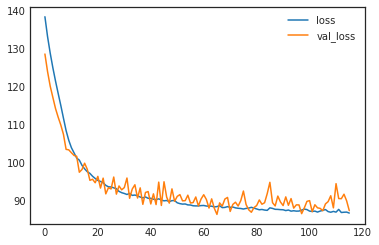

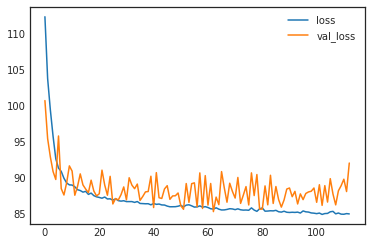

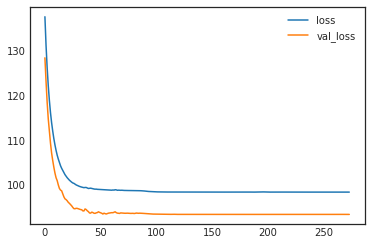

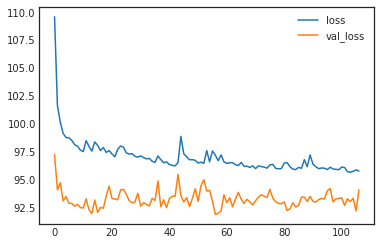

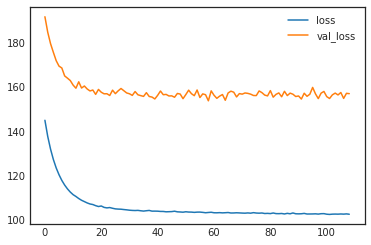

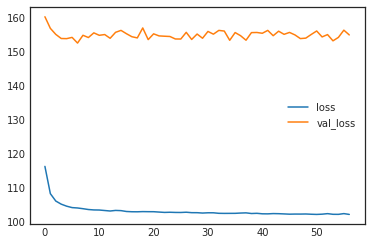

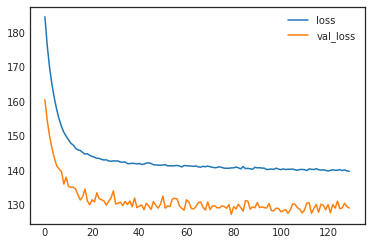

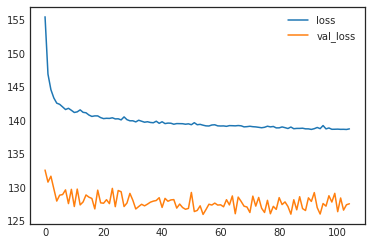

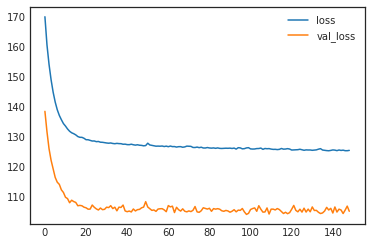

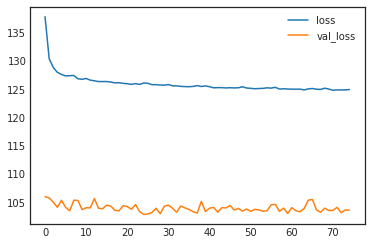

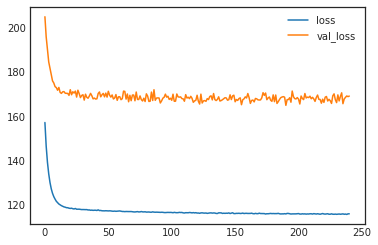

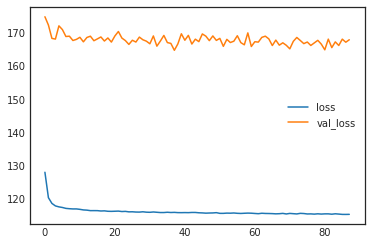

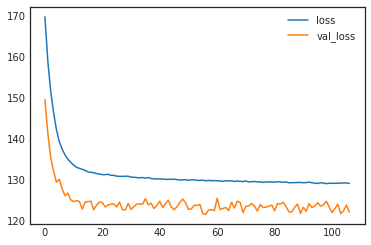

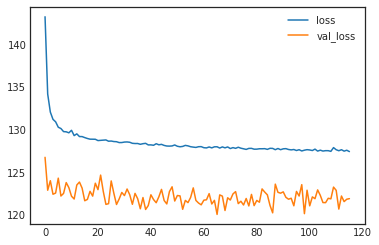

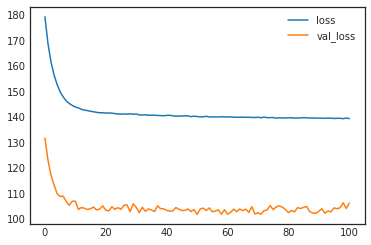

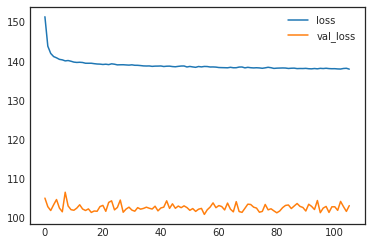

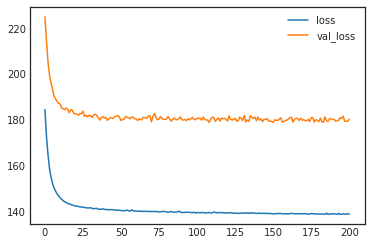

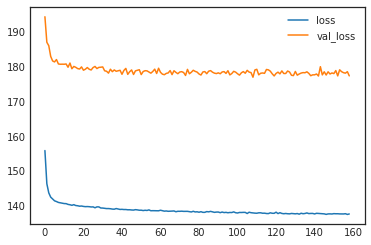

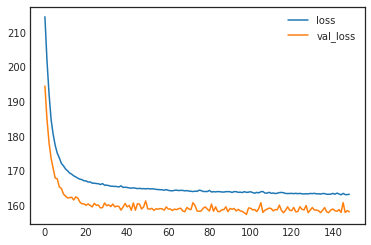

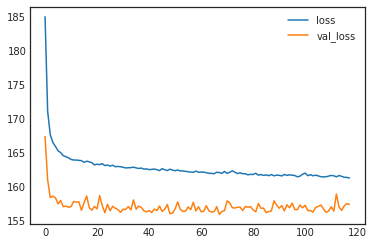

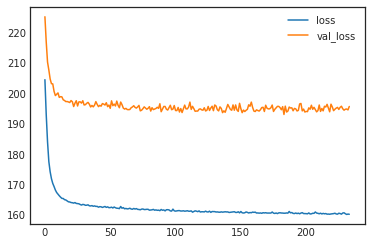

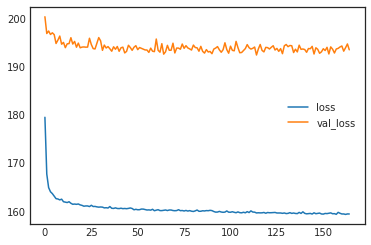

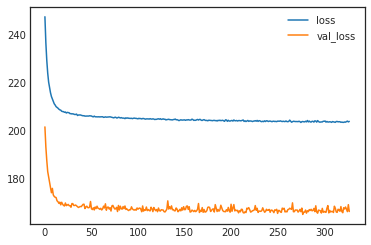

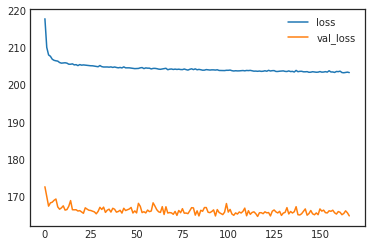

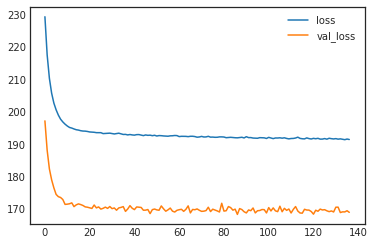

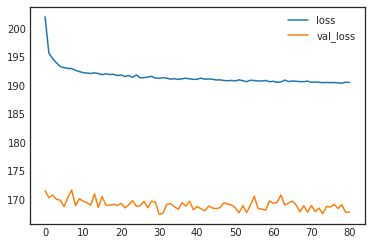

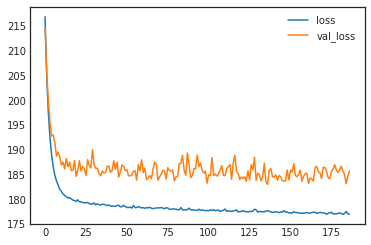

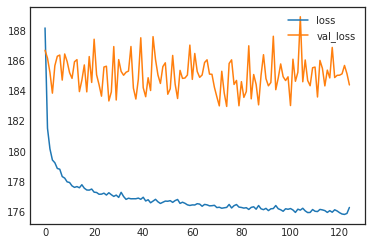

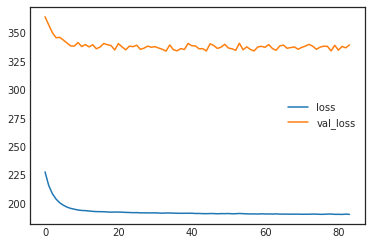

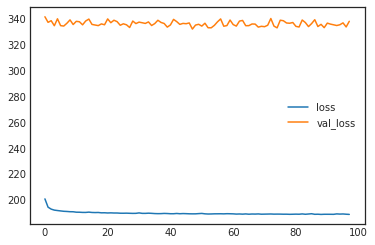

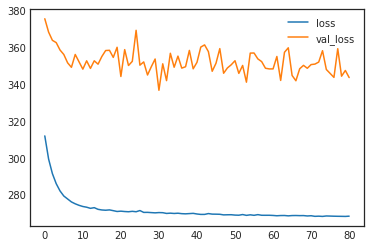

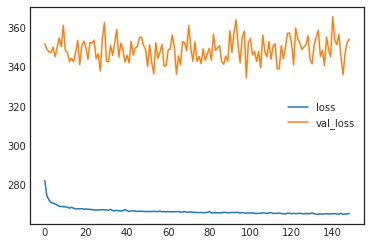

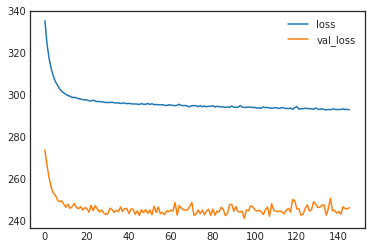

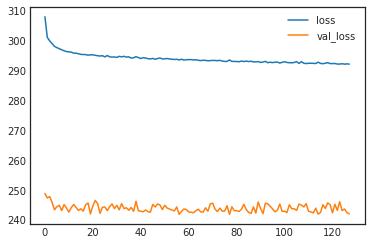

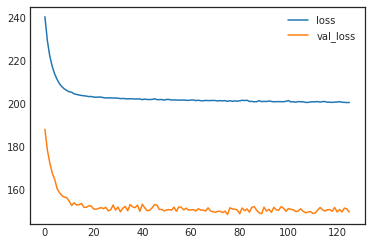

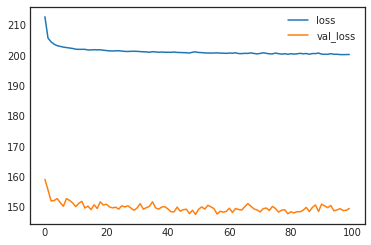

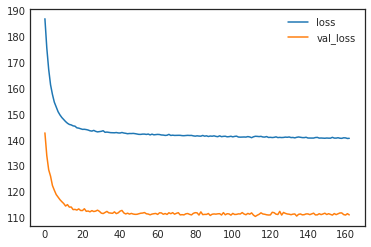

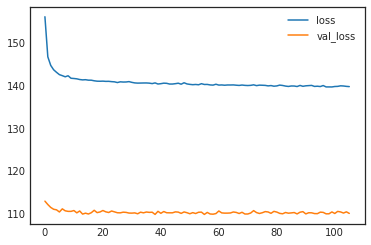

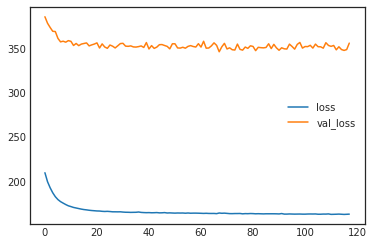

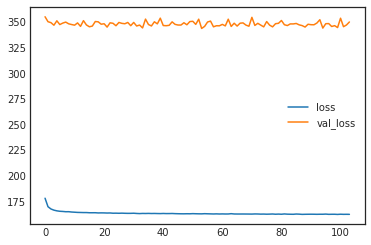

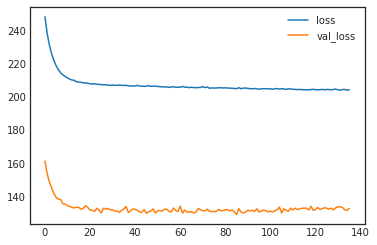

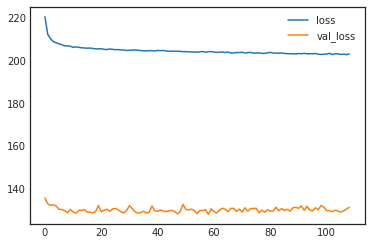

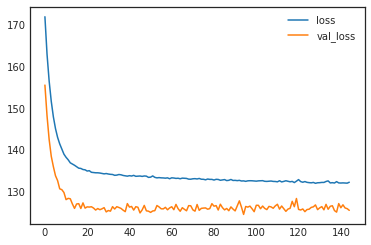

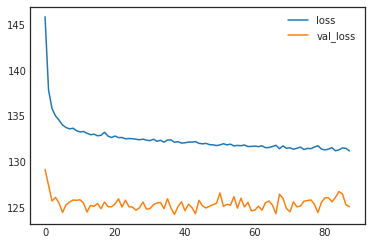

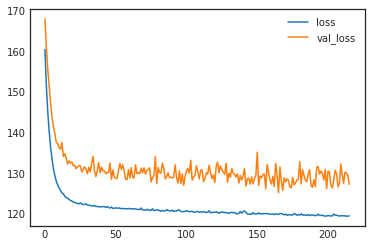

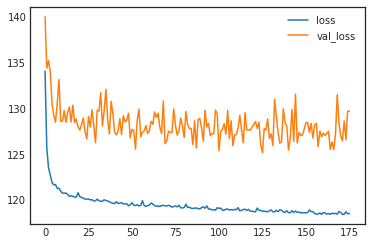

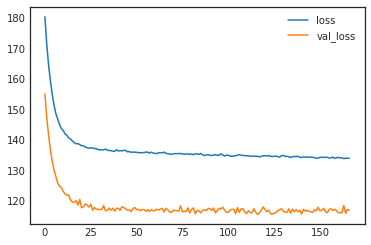

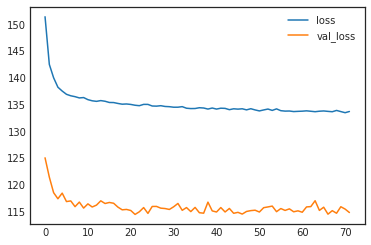

In [5]:
min_prd_list = range(100, 676, 25)
# min_prd_list = [100, 160, 220, 280, 340, 400, 455, 510, 565, 620, 655]
#min_prd_list = [100, 160, 220, 280, 340, 400]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_xgb_regularizer=0.2
optuna_xgb_trials = 50
optuna_nn_trials = 100

time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    #display(X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())
    display(X_train.shape, X_val.shape, X_test.shape)

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective_xgb(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_xgb_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgb, n_trials=optuna_xgb_trials)
    print('Total time for hypermarameter optimization, XGB: ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]
    
    ###########
    ### NNs ###
    ###########
    
    neurons_base = 8
    l2_reg_rate = 0.5

    model_snn6 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn6.count_params())

    early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
    optimizer_adam = tf.keras.optimizers.Adam()

    model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
    [r2_score(y_train, model_snn6.predict(X_train)), 
    r2_score(y_val, model_snn6.predict(X_val)),
    r2_score(y_test, model_snn6.predict(X_test))]
    
    
    
    neurons_base = 8
    l2_reg_rate = 0.3

    model_snn4 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn4.count_params())

    time1 = time.time()
    model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
    [r2_score(y_train, model_snn4.predict(X_train)), 
    r2_score(y_val, model_snn4.predict(X_val)),
    r2_score(y_test, model_snn4.predict(X_test))]
    
    
    
    # try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

    time1 = time.time()
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn4, n_trials=optuna_nn_trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display('Optuna NN4', study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print('Time for hyperparameter optimization: ',time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn4_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                             l2_reg_rate=optimal_hyperpars[1],
                                            l1_reg_rate=optimal_hyperpars[2])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=0, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    
    time1 = time.time()
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn6, n_trials=optuna_nn_trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display('Optuna NN6', study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print('Time for hyperparameter optimization: ', time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn6_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                             l2_reg_rate=optimal_hyperpars[1],
                                            l1_reg_rate=optimal_hyperpars[2])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=0, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn6opt_train':'nn6opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    
    
    display(results)
    
    results.to_csv('temp_models_reg005_1')
    
display(results)

In [6]:
temp

{'neurons_base': 10,
 'l2_regularizer': 0.811377330057798,
 'l1_regularizer': 0.12740219569157527}

In [7]:
study.best_params

{'neurons_base': 10,
 'l2_regularizer': 0.811377330057798,
 'l1_regularizer': 0.12740219569157527}

In [8]:
list(study.best_params.values())[1]

0.811377330057798

In [9]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      0.087058
xgbf_val        0.039040
xgbf_test       0.022551
xgbgs_train     0.090018
xgbgs_val       0.092872
xgbgs_test      0.029898
xgbo_train      0.072770
xgbo_val        0.075919
xgbo_test       0.027926
nn4_train       0.062765
nn4_val         0.049242
nn4_test        0.021533
nn6_train       0.062087
nn6_val         0.049689
nn6_test        0.020760
nn4opt_train    0.044584
nn4opt_val      0.043367
nn4opt_test     0.021340
nn6opt_train    0.041006
nn6opt_val      0.038253
nn6opt_test     0.017594
dtype: float64

34173.310643196106


In [10]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [11]:
print('total time for the script: ', time.time()-time0)
display(results)

total time for the script:  34173.81423139572


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,100,0.203674,0.035883,-0.01135,0.197144,0.113951,0.015671,0.15318,0.070222,0.009234,0.172782,0.045885,-0.026978,0.167039,0.065236,-0.014712,-0.000001,-0.000944,-0.000859,-0.000001,-0.000937,-0.000853
1,125,0.099479,0.039111,0.008778,0.07184,0.086386,0.017087,0.064558,0.081187,0.005728,0.034748,0.033056,0.001889,-0.000057,-0.0,-0.000002,0.025606,0.027189,0.00664,0.048298,0.034415,0.011549
2,150,0.0821,0.021046,0.026281,0.09783,0.133871,0.033129,0.05197,0.068892,0.021971,0.027771,0.035985,0.008974,0.044607,0.033099,0.021165,0.0381,0.030363,0.012253,-0.000003,-0.000047,-0.000027
3,175,0.094787,0.023411,-0.023785,0.062416,0.050588,-0.029834,0.097112,0.078249,-0.036516,0.074567,0.025346,-0.054409,0.070595,0.027007,-0.07594,0.074126,0.026729,-0.066467,0.065063,0.02197,-0.060761
4,200,0.082007,0.023224,-0.003457,0.135024,0.093293,0.016363,0.043375,0.034795,0.008833,0.049414,0.031332,0.002124,0.05978,0.030317,0.006897,-0.0,-0.000006,-0.000062,0.048445,0.026205,-0.001675
5,225,0.069808,0.061418,0.032658,0.095249,0.137579,0.017908,0.064951,0.099325,0.021232,0.048233,0.082121,0.002713,0.05322,0.084425,0.001054,0.051497,0.081906,0.010312,0.059701,0.088011,-0.003948
6,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.065766,0.016415,0.025622,0.076417,-0.003259,0.012283,0.071003,-0.003144,0.006258,-0.0,-0.000027,-0.000011,-0.0,-0.000017,-0.000005
7,275,0.069326,0.017614,0.054105,0.042084,0.037943,0.066126,0.049154,0.041832,0.056659,0.048503,0.026835,0.063409,0.046251,0.031042,0.053487,0.052664,0.018979,0.060427,0.058547,0.021157,0.061718
8,300,0.126142,0.125137,0.089316,0.137684,0.177626,0.099763,0.134544,0.170607,0.100799,0.108161,0.142227,0.104616,0.110147,0.140496,0.099149,0.10347,0.140834,0.100377,0.101239,0.139393,0.105443
9,325,0.139577,0.082703,0.100918,0.116229,0.095541,0.102465,0.123712,0.095535,0.104456,0.12769,0.084852,0.105973,0.128076,0.084723,0.110664,0.120158,0.08546,0.104857,0.128879,0.085449,0.106411


In [12]:
 
# def objective_nn(trial):
    
#     tf.keras.backend.clear_session()
    
#     with strategy.scope():
#         # Generate our trial model.
#         model = create_snnn_model(trial)

#         callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=40),
#         TFKerasPruningCallback(trial, "val_loss"),
#     ]

#         # Fit the model on the training data.
#         # The TFKerasPruningCallback checks for pruning condition every epoch.
        
#         history = model.fit(X_train, y_train, 
#                                 validation_data=(X_val, y_val),
#                                 batch_size=2048, 
#                                 epochs=500, 
#                                 verbose=1, 
#                                 callbacks=callbacks)

#         # Evaluate the model accuracy on the validation set.
#         score = model.evaluate(X_val, y_val, verbose=0)
#         return score[1]

# trials = 50

# study = optuna.create_study(direction="minimize", 
#                             sampler=optuna.samplers.TPESampler(), 
#                             pruner=optuna.pruners.HyperbandPruner())
# study.optimize(objective_nn, n_trials=trials)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
# temp = study.best_params
# display(study.best_params, time.time()-time1)

# optimal_hyperpars = list(temp.values())
# display(optimal_hyperpars)
# print(time.time()-time1, optimal_hyperpars)

# optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
# history = optuna_nn.fit(X_train, y_train, 
#                         validation_data=(X_val, y_val),
#                         batch_size=2048, 
#                         epochs=1000,
#                         verbose=1, 
#                         callbacks=[early_stopping50])

# results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
# [r2_score(y_train, optuna_nn.predict(X_train)), 
# r2_score(y_val, optuna_nn.predict(X_val)),
# r2_score(y_test, optuna_nn.predict(X_test))]

In [13]:
results.to_csv('temp_models_1')

In [14]:
# # try optuna for NN:

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     model = tf.keras.Sequential()
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
#     model.add(tf.keras.layers.Dense(1))
#     display(model.summary())
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)


In [15]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [16]:
# usually self-norm seems better: it overfits less and runs faster

